In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [2]:
def fetch_mnist(url: str):
    import requests, gzip, hashlib, tempfile, os
    
    tmp_path = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.exists(tmp_path):
        with open(tmp_path, 'rb') as f:
            data = f.read()
    else:
        res = requests.get(url, stream=True)
        total = res.headers.get('content-length')
        
        if total is None:
            total = 0
        
        total = int(total)
        
        block_size = 1024
        progress_bar = tqdm(total=total, unit='iB', unit_scale=True)
        
        with open(tmp_path, 'wb+') as f:
            for iter_data in res.iter_content(block_size):
                progress_bar.update(len(iter_data))
                f.write(iter_data)
            data = f.read()
        progress_bar.close()

    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()


X_train = fetch_mnist('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[16:].reshape(-1, 28, 28)
Y_train = fetch_mnist('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch_mnist('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[16:].reshape(-1, 28, 28)
Y_test = fetch_mnist('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [3]:
X_train = (X_train / 255.).reshape((-1, 28 * 28))
X_test = (X_test / 255.).reshape((-1, 28 * 28))

In [4]:
def to_categorical(y, num_classes=10):
    return np.eye(num_classes)[y]

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [5]:
class Linear:
    def __init__(self, input_size, output_size, bias=True):
        self.params = {}
        self.grads = {}
        self.params["w"] = np.random.uniform(-1., 1., size=(input_size, output_size))/np.sqrt(input_size*output_size)

        if bias:
            self.params["b"] = np.random.uniform(-1., 1., size=(output_size))/np.sqrt(output_size)

        else:
            self.params['b'] = np.zeros_like(output_size)

    def forward(self, x):
        self.x = x
        return np.dot(self.x, self.params['w']) + self.params['b']
    
    def backward(self, grad):
        self.grads['b'] = np.sum(grad)
        self.grads['w'] = self.x.T @ grad 

        return grad @ self.params['w'].T

    def __call__(self, inputs):
        return self.forward(inputs)

In [6]:
class MSE:
    # Not really Mean Squared Error
    def loss(self, yHat, y):
        return np.sum((yHat - y)**2, axis=1)
    
    def grad(self, yHat, y):
        return 2 * (yHat - y)

    def __call__(self, yHat, y):
        return self.loss(yHat, y)

In [7]:
class BatchIterator:
    def __init__(self, x, y, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x
        self.y = y
        self.batch_iter_count = round(len(self.x) / self.batch_size)
        
    def __call__(self):
        assert len(self.x) == len(self.y)
        starts = np.arange(0, len(self.x), self.batch_size)
        
        if self.shuffle:
            np.random.shuffle(starts)
        
        for start in starts:
            end = start + self.batch_size
            batch_x = self.x[start:end]
            batch_y = self.y[start:end]
            
            yield (batch_x, batch_y)

In [8]:
class SGD:
    def __init__(self, lr=1e-3):
        self.lr = lr
        
    def step(self, model):
        for param, grad in model.get_params_and_grads():
            param -= self.lr * grad

In [9]:
class Model:
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return grad
    
    def fit(self, batch_dataset, epochs = 10, loss = MSE(), optim = SGD(), validation_data=()):
        history = {
            'train_loss': [],
            'val_accuracy': [],
            'val_loss': []
        }

        for epoch in range(epochs):
            epoch_loss = 0.0
            batch_iterator = tqdm(batch_dataset(), total=batch_dataset.batch_iter_count, unit=' batch(s)')
            for idx, batch in enumerate(batch_iterator):
                yHat = self.forward(batch[0])
                epoch_loss += loss.loss(yHat, batch[-1])
                grad = loss.grad(yHat, batch[-1])
                self.backward(grad)
                optim.step(self)
                batch_iterator.set_description(f"Epoch {epoch + 1}/{epochs}")
                ## batch_iterator.set_postfix({f"batch_accuracy": pvalue(batch[0], batch[-1])})
                
                if idx == batch_dataset.batch_iter_count - 1:
                    val_loss = np.average(loss.loss(self.forward(validation_data[0]), validation_data[-1]))
                    val_accuracy = self.evaluate(*validation_data)
                    batch_iterator.set_postfix({
                        'val_accuracy': val_accuracy,
                        'val_loss': val_loss
                })
                    
            epoch_loss /= idx
            history['train_loss'].append(epoch_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_loss'].append(val_loss)
        
        history['train_loss'] = np.average(np.array(history['train_loss']), axis=1)
        history['val_accuracy'] = np.array(history['val_accuracy'])
                
        return history
    
    def get_params_and_grads(self):
        for layer in self.layers:
            for name, param in layer.params.items():
                grad = layer.grads[name]
                yield param, grad

    def __call__(self, x):
        return self.forward(x)
    
    def evaluate(self, x_test, y):
        return evaluate_model(self, x_test, y)
    
def evaluate_model(model, x_test, y):
    y_mega_hat = model.forward(x_test)
    preds = np.array([np.argmax(i) for i in y_mega_hat])
    actuals = np.array([np.argmax(i) for i in y])
    simi = preds == actuals
    
    return np.count_nonzero(simi)/len(simi)

In [10]:
class ReLu:
    def __init__(self):
        self.params = {}
        self.grads = {}

    def forward(self, x):
        self.x = x
        return np.maximum(0, self.x)
        
    def backward(self, grad):
        return 1 * (self.x > 0) * grad

    def __call__(self, x):
        return self.forward(x)

In [11]:
input_shape = np.product(X_train[0].shape)


model = Model([
    Linear(input_shape, 128),
    ReLu(),
    Linear(128, 64),
    ReLu(),
    Linear(64, 10)
])

In [12]:
accuracy = model.evaluate(X_test, Y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.1032


In [13]:
history = model.fit(BatchIterator(X_train, Y_train), epochs=10, validation_data=(X_test, Y_test))

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

  0%|          | 0/1875 [00:00<?, ? batch(s)/s]

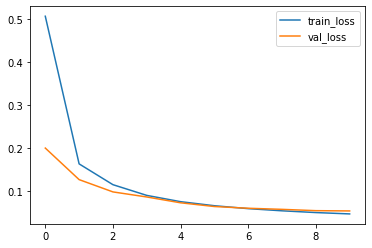

In [14]:
epochs = np.arange(len(history['train_loss']))
plt.plot(epochs, history['train_loss'], history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

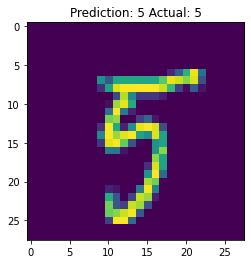

In [15]:
index = np.random.choice(len(X_test))
pred = np.argmax(model.forward(X_test[index]))

plt.imshow(X_test[index].reshape(28, 28))
plt.title(f"Prediction: {pred} Actual: {np.argmax(Y_test[index])}")
plt.show()